In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
reddit_data = pd.read_csv("C:/Users/ABC/Downloads/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv")
twitter_data = pd.read_csv("C:/Users/ABC/Downloads/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")

In [14]:
def cleanText(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    cleanedText = ' '.join(''.join([i for i in string if not i.isdigit()]).split())
    
    for i in punc:
        cleanedText = cleanedText.replace(i, '')
        
    a = [i for i in cleanedText if i.isalpha() or i == ' ']
            
    final_text = ' '.join(''.join(a).split())
    return final_text

Cleaning Data

In [13]:
reddit_data = reddit_data.dropna(how='any')
twitter_data = twitter_data.dropna(how='any')

In [15]:
reddit_data.rename(columns={'clean_comment':'comment'}, inplace=True)
twitter_data.rename(columns={'clean_text':'comment'}, inplace=True)

reddit_data.category = reddit_data.category.apply(lambda x: int(x))
twitter_data.category = twitter_data.category.apply(lambda x: int(x))

reddit_data.comment = reddit_data.comment.apply(cleanText)
twitter_data.comment = twitter_data.comment.apply(cleanText)

In [16]:
reddit_data.drop_duplicates(subset='comment', keep=False, inplace=True)
twitter_data.drop_duplicates(subset='comment', keep=False, inplace=True)

In [17]:
concat_df = pd.concat([reddit_data,twitter_data], ignore_index=True)
concat_df.drop_duplicates(subset='comment', keep=False, inplace=True)

Data Visualisation

In [18]:
counts = [len(reddit_data), len(twitter_data), len(concat_df)]
labels = ['Reddit', 'Twitter', 'Total']
colors = ['#ff4500', '#1DA1F2', '#50C878']

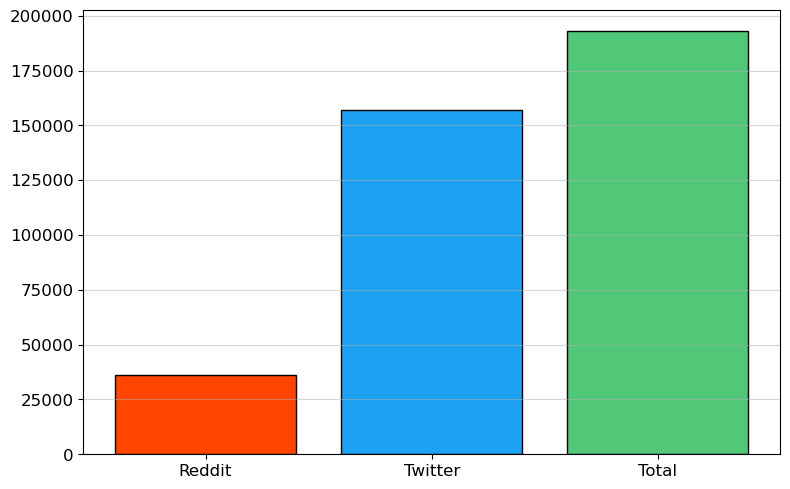

In [19]:
plt.figure(figsize=(8,5))
plt.bar(labels, counts, color=colors, edgecolor = 'black')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

Count the Negative,Neutral and Positive comments

In [23]:
negative_count = [len(reddit_data[reddit_data.category == -1]),
                 len(twitter_data[twitter_data.category == -1]),
                 len(concat_df[concat_df.category == -1])]

neutral_count = [len(reddit_data[reddit_data.category == 0]),
                 len(twitter_data[twitter_data.category == 0]),
                 len(concat_df[concat_df.category == 0])]

positive_count = [len(reddit_data[reddit_data.category == 1]),
                 len(twitter_data[twitter_data.category == 1]),
                 len(concat_df[concat_df.category == 1])]

x = ['Reddit', 'Twitter', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

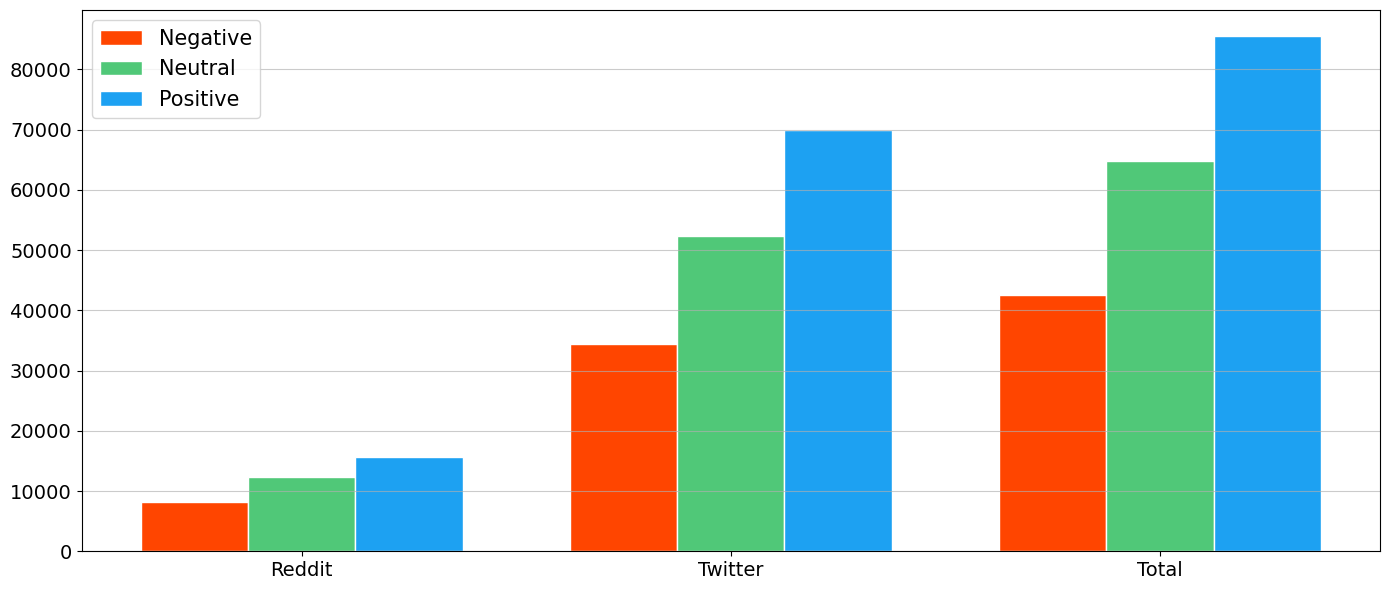

In [24]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()


Count the Average length of all the three Sentiment's comments

In [25]:
negative_avg = int(sum([len(i) for i in concat_df[concat_df.category == -1].comment]) / len(concat_df[concat_df.category == 1]))
neutral_avg = int(sum([len(i) for i in concat_df[concat_df.category == 0].comment]) / len(concat_df[concat_df.category == 0]))
positive_avg = int(sum([len(i) for i in concat_df[concat_df.category == 1].comment]) / len(concat_df[concat_df.category == 1]))

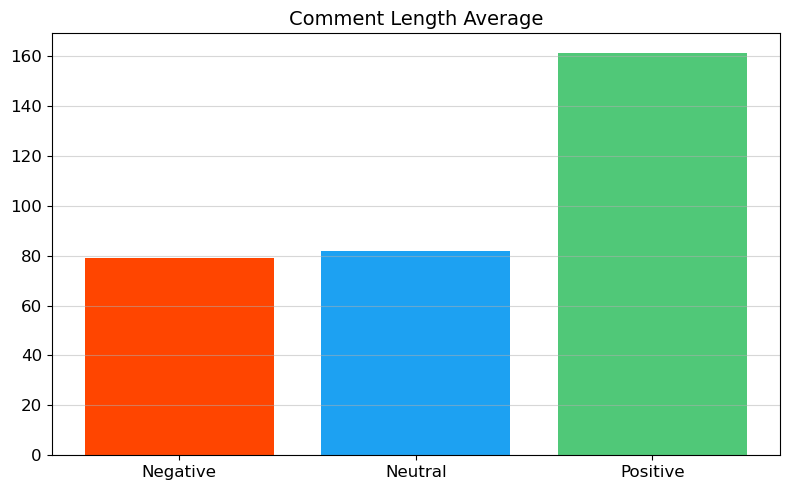

In [26]:
plt.figure(figsize=(8,5))

plt.bar(['Negative', 'Neutral', 'Positive'], [negative_avg, neutral_avg, positive_avg], color=colors)

plt.title('Comment Length Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

Split Test and Train Data

In [40]:
class Data:
    def __init__(self, df):
        self.df = df
        
    def fixData(self):
        dataframe = self.df
        lowest_len = min([i for i in dataframe.category.value_counts()])
        
        # Create the final data frame
        final_df = pd.concat([dataframe[dataframe.category == -1][:lowest_len],
                             dataframe[dataframe.category == 0][:lowest_len],
                             dataframe[dataframe.category == 1][:lowest_len]])
        
        # To shuffle the rows in the data frame
        final_df = final_df.sample(frac=1).reset_index(drop=True)
        return final_df


Split Train and Test data

In [41]:
a = Data(concat_df)
fixed_df = a.fixData()
print(f'Before: \n{concat_df.category.value_counts()}\n')
print(f'After: \n{fixed_df.category.value_counts()}')

Before: 
 1    85581
 0    64771
-1    42628
Name: category, dtype: int64

After: 
-1    42628
 0    42628
 1    42628
Name: category, dtype: int64


In [42]:
train_X, test_X, train_y, test_y = train_test_split([i for i in fixed_df.comment], [i for i in fixed_df.category], test_size=0.25, random_state=1)

Vectorize the Comment

In [44]:
vectorizer = TfidfVectorizer()
train_X_vectors = vectorizer.fit_transform(train_X)
test_X_vectors = vectorizer.transform(test_X)

Creating Models

Linear SVC

In [45]:
clf_svm = LinearSVC()
clf_svm.fit(train_X_vectors, train_y)
clf_prediction = clf_svm.predict(test_X_vectors)

print(f'Accuracy: {clf_svm.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, clf_prediction, average=None, labels=[-1, 0, 1])}')

C:\Users\ABC\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.93440930843577
Accuracy: [0.91914975 0.96211293 0.92067546]


MultinomiaINB

In [46]:
svm_mnb = MultinomialNB()
svm_mnb.fit(train_X_vectors, train_y)
mnb_prediction = svm_mnb.predict(test_X_vectors)

print(f'Accuracy: {svm_mnb.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, mnb_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.6888742923274217
Accuracy: [0.71424542 0.58788031 0.7309531 ]


Decision Tree Classifier

In [48]:
svm_dtc = DecisionTreeClassifier()
svm_dtc.fit(train_X_vectors, train_y)
dtc_prediction = svm_dtc.predict(test_X_vectors)

print(f'Accuracy: {svm_dtc.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, dtc_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.7638484876919709
Accuracy: [0.71012863 0.82902426 0.74597025]
